In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates


In [23]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the data
data = pd.read_csv("QVI_data.csv")

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [25]:
# Convert 'DATE' column to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

In [26]:
# Create a 'YEARMONTH' column (YYYYMM format) [cite: 20]
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Calculate measures over time for each store [cite: 22]
# We group by Store and YearMonth to get monthly aggregates
measureOverTime = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / x.nunique()),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

# Filter to stores with full observation periods (12 months of data) in the pre-trial period
# Pre-trial is defined as before 201902 [cite: 32, 33, 34]
store_counts = measureOverTime['STORE_NBR'].value_counts()
storesWithFullObs = store_counts[store_counts == 12].index

preTrialMeasures = measureOverTime[
    (measureOverTime['YEARMONTH'] < 201902) & 
    (measureOverTime['STORE_NBR'].isin(storesWithFullObs))
].copy()

print(f"Number of stores with full pre-trial observations: {len(storesWithFullObs)}")

Number of stores with full pre-trial observations: 260


In [27]:
def calculate_correlation(input_table, metric_col, trial_store):
    """
    Calculates correlation between trial store and all other stores for a specific metric.
    """
    trial_data = input_table[input_table['STORE_NBR'] == trial_store][metric_col].reset_index(drop=True)
    
    # We can use pandas vectorization efficiently here
    # Pivot table to have stores as columns, months as rows
    pivot_table = input_table.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric_col)
    
    # Calculate correlation of all stores against the trial store
    correlations = pivot_table.corrwith(pivot_table[trial_store])
    
    # Format into a DataFrame
    corr_table = pd.DataFrame({
        'Store1': trial_store,
        'Store2': correlations.index,
        'corr_measure': correlations.values
    })
    
    # Remove the trial store comparing to itself
    return corr_table[corr_table['Store2'] != trial_store].dropna()

def calculate_magnitude_distance(input_table, metric_col, trial_store):
    """
    Calculates standardized magnitude distance between trial store and other stores.
    """
    trial_data = input_table[input_table['STORE_NBR'] == trial_store].set_index('YEARMONTH')[metric_col]
    
    # Create a list to store results
    dist_list = []
    
    store_numbers = input_table['STORE_NBR'].unique()
    
    for i in store_numbers:
        if i == trial_store:
            continue
            
        control_data = input_table[input_table['STORE_NBR'] == i].set_index('YEARMONTH')[metric_col]
        
        # Ensure indices match (join on YearMonth)
        diff = abs(trial_data - control_data)
        
        # Create temporary df
        temp_df = pd.DataFrame({
            'Store1': trial_store,
            'Store2': i,
            'YEARMONTH': diff.index,
            'measure': diff.values
        })
        dist_list.append(temp_df)

    calcDistTable = pd.concat(dist_list)
    
    # Standardize the magnitude distance so that the measure ranges from 0 to 1 [cite: 75]
    # (x - min) / (max - min)
    min_max = calcDistTable.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max'])
    calcDistTable = calcDistTable.merge(min_max, on=['Store1', 'YEARMONTH'])
    
    # 1 - ((measure - min) / (max - min))
    calcDistTable['magnitudeMeasure'] = 1 - (
        (calcDistTable['measure'] - calcDistTable['min']) / 
        (calcDistTable['max'] - calcDistTable['min'])
    )
    
    # Average magnitude over time
    finalDistTable = calcDistTable.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    return finalDistTable.rename(columns={'magnitudeMeasure': 'mag_measure'})

In [28]:
trial_store = 77

# Calculate Correlation [cite: 89, 91]
corr_nSales = calculate_correlation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(preTrialMeasures, 'nCustomers', trial_store)

# Calculate Magnitude [cite: 94, 96]
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'nCustomers', trial_store)

# Combine Scores (Weight = 0.5) [cite: 102]
corr_weight = 0.5

score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (score_nSales['corr_measure'] * corr_weight) + (score_nSales['mag_measure'] * (1 - corr_weight))

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (score_nCustomers['corr_measure'] * corr_weight) + (score_nCustomers['mag_measure'] * (1 - corr_weight))

# Final Combined Score [cite: 114]
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = (score_Control['scoreNSales'] * 0.5) + (score_Control['scoreNCust'] * 0.5)

# Select control store with highest score [cite: 119]
control_store = score_Control.sort_values(by='finalControlScore', ascending=False).iloc[0]['Store2']
print(f"Selected Control Store for Trial Store {trial_store} is: {int(control_store)}")

Selected Control Store for Trial Store 77 is: 233


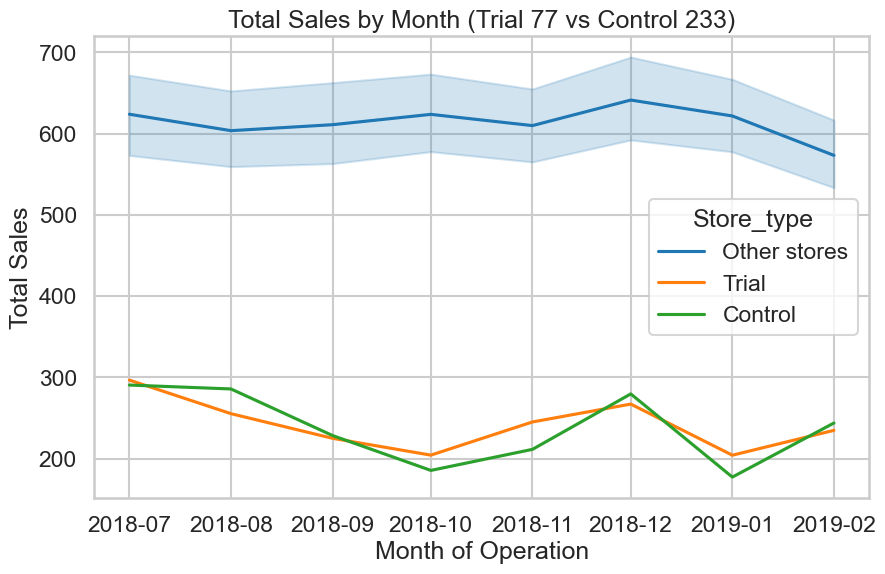

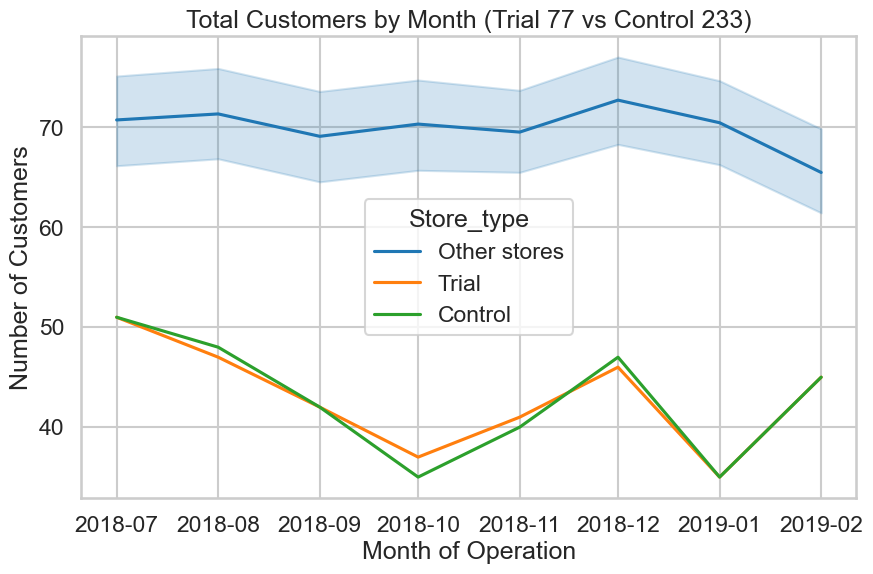

In [29]:
# Prepare data for plotting [cite: 126]
measureOverTime['Store_type'] = np.where(measureOverTime['STORE_NBR'] == trial_store, "Trial",
                                np.where(measureOverTime['STORE_NBR'] == control_store, "Control", "Other stores"))

pastSales = measureOverTime[measureOverTime['YEARMONTH'] < 201903].copy()
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

# Calculate mean sales for "Other stores" for comparison logic (optional, but follows R structure)
# However, the plot specifically focuses on Trial vs Control vs Other
# We will filter to just the relevant types for the specific plot in the PDF [cite: 139]

# Aggregate "Other stores" to get a mean line (optional, implied by R code aggregation)
# But strictly following the PDF plot, it shows specific lines.
# Let's plot Trial vs Control directly.

plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales[pastSales['Store_type'].isin(["Trial", "Control", "Other stores"])], 
             x='TransactionMonth', y='totSales', hue='Store_type')
plt.title(f"Total Sales by Month (Trial {trial_store} vs Control {int(control_store)})")
plt.ylabel("Total Sales")
plt.xlabel("Month of Operation")
plt.savefig("Total_Sales_by_Month.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales[pastSales['Store_type'].isin(["Trial", "Control", "Other stores"])], 
             x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.title(f"Total Customers by Month (Trial {trial_store} vs Control {int(control_store)})")
plt.ylabel("Number of Customers")
plt.xlabel("Month of Operation")
plt.savefig("Total_Customers_by_Month.png", dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# Before performing t-tests, we verify if the pre-trial sales data follows a Normal Distribution.
# We use the Shapiro-Wilk test for Normality.

print("Normality Test (Shapiro-Wilk) for Control Store Sales\n")
stat, p_value = stats.shapiro(preTrialMeasures['totSales'])

print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")

if p_value > 0.05:
    print("Result: Fail to reject H0. The data looks Normal (Gaussian).")
else:
    print("Result: Reject H0. Data is not perfectly Normal.")

Normality Test (Shapiro-Wilk) for Control Store Sales

Statistic: 0.9400, p-value: 0.0000
Result: Reject H0. Data is not perfectly Normal.


In [31]:
# Statistical Significance Testing
sales_trial = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
sales_control = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
scalingFactorSales = sales_trial / sales_control


scaledControlSales = measureOverTime[measureOverTime['STORE_NBR'] == control_store].copy()
scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales

trial_data = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']].reset_index(drop=True)
control_data = scaledControlSales[['YEARMONTH', 'controlSales']].reset_index(drop=True)

percentageDiff = pd.merge(trial_data, control_data, on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']

#Calculate Standard Deviation (Pre-trial)
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Calculate t-values for the Trial Period 
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y%m')

print("T-Values for Trial Period:")
print(percentageDiff[(percentageDiff['YEARMONTH'] >= 201902) & (percentageDiff['YEARMONTH'] <= 201904)][['TransactionMonth', 'tValue']])

# Critical Value (95th percentile, df=7)
degreesOfFreedom = 7 
critical_value = t.ppf(0.95, degreesOfFreedom)
print(f"\nCritical t-value (95%): {critical_value}")

T-Values for Trial Period:
  TransactionMonth     tValue
7       2019-02-01   1.183534
8       2019-03-01   7.339116
9       2019-04-01  12.476373

Critical t-value (95%): 1.894578605061305


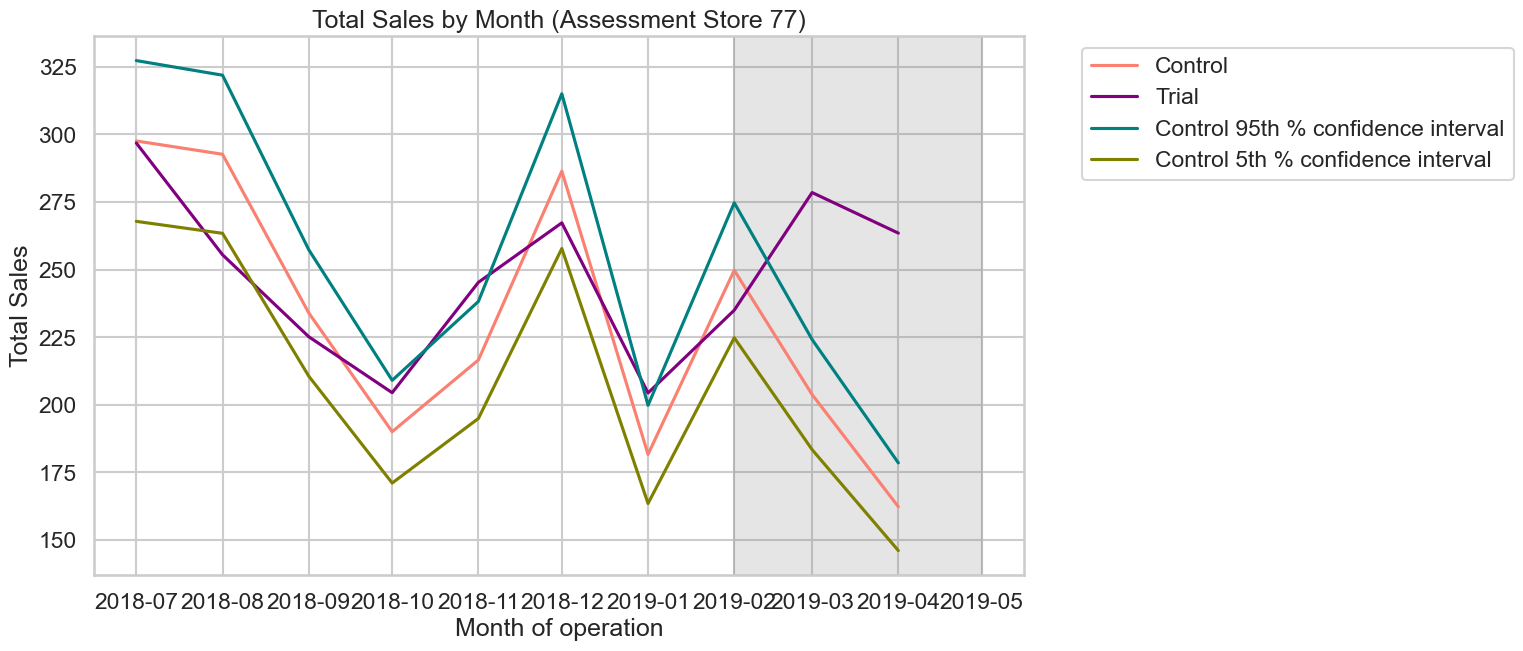

In [32]:

# We take the scaled control sales and apply the margin of error
trialAssessment = scaledControlSales.copy()
trialAssessment['TransactionMonth'] = pd.to_datetime(trialAssessment['YEARMONTH'].astype(str), format='%Y%m')
trialAssessment = trialAssessment[['TransactionMonth', 'YEARMONTH', 'controlSales']].rename(columns={'controlSales': 'totSales'})
trialAssessment['Store_type'] = "Control"

# Add Trial Data
trialDataPlot = measureOverTime[measureOverTime['STORE_NBR'] == trial_store].copy()
trialDataPlot['TransactionMonth'] = pd.to_datetime(trialDataPlot['YEARMONTH'].astype(str), format='%Y%m')
trialDataPlot = trialDataPlot[['TransactionMonth', 'YEARMONTH', 'totSales']]
trialDataPlot['Store_type'] = "Trial"

# Create Confidence Intervals (Controls)
# 95th Percentile
control95 = trialAssessment.copy()
control95['totSales'] = control95['totSales'] * (1 + stdDev * 2)
control95['Store_type'] = "Control 95th % confidence interval"

# 5th Percentile
control5 = trialAssessment.copy()
control5['totSales'] = control5['totSales'] * (1 - stdDev * 2)
control5['Store_type'] = "Control 5th % confidence interval"

# Combine
combined_plot = pd.concat([trialAssessment, trialDataPlot, control95, control5])

# Plotting 
plt.figure(figsize=(12, 7))

# Highlight Trial Period (March - April approx, PDF visual suggests shading)
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-05-01'), color='grey', alpha=0.2)

sns.lineplot(data=combined_plot[combined_plot['YEARMONTH'] < 201905], 
             x='TransactionMonth', y='totSales', hue='Store_type', 
             palette={'Control': 'salmon', 'Trial': 'purple', 
                      'Control 95th % confidence interval': 'teal', 
                      'Control 5th % confidence interval': 'olive'})

plt.title("Total Sales by Month (Assessment Store 77)")
plt.xlabel("Month of operation")
plt.ylabel("Total Sales")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("Total_Sales_Assessment_Store_77.png", dpi=300, bbox_inches='tight')
plt.show()

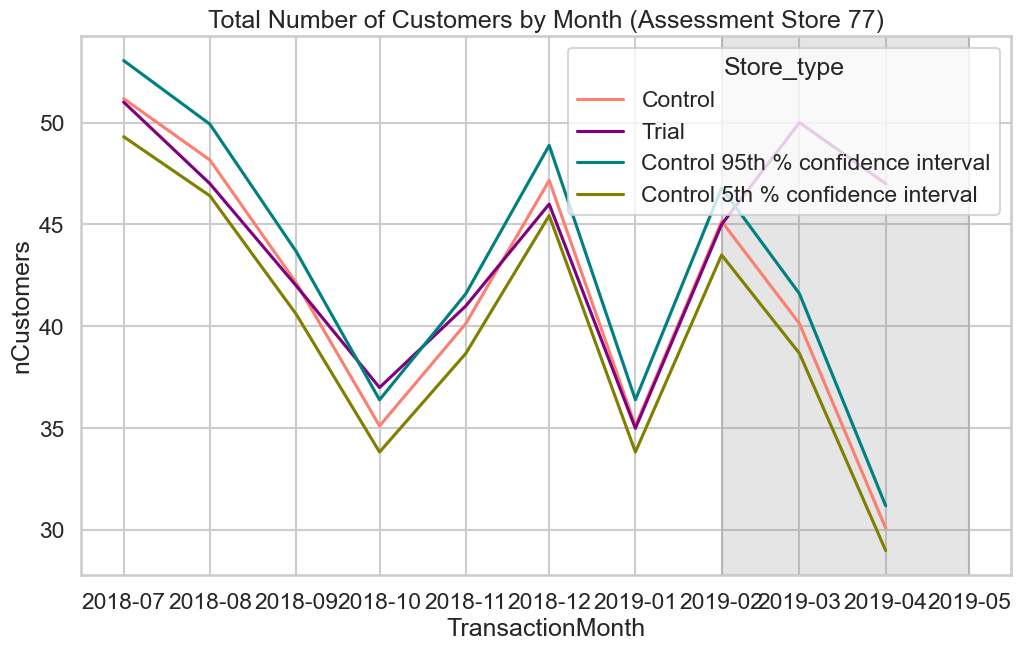

In [33]:
# 1. Scale Control Customers
cust_trial = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()
cust_control = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['YEARMONTH'] < 201902)]['nCustomers'].sum()
scalingFactorCust = cust_trial / cust_control

# Apply scaling
scaledControlCust = measureOverTime[measureOverTime['STORE_NBR'] == control_store].copy()
scaledControlCust['controlCust'] = scaledControlCust['nCustomers'] * scalingFactorCust

# 2. Percentage Diff & Std Dev
trial_data_c = measureOverTime[measureOverTime['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']].reset_index(drop=True)
control_data_c = scaledControlCust[['YEARMONTH', 'controlCust']].reset_index(drop=True)

percentageDiffC = pd.merge(trial_data_c, control_data_c, on='YEARMONTH')
percentageDiffC['percentageDiff'] = abs(percentageDiffC['controlCust'] - percentageDiffC['nCustomers']) / percentageDiffC['controlCust']
stdDevC = percentageDiffC[percentageDiffC['YEARMONTH'] < 201902]['percentageDiff'].std()

# 3. Plotting
# Prepare plot data
controlCustPlot = scaledControlCust.copy()
controlCustPlot['TransactionMonth'] = pd.to_datetime(controlCustPlot['YEARMONTH'].astype(str), format='%Y%m')
controlCustPlot = controlCustPlot[['TransactionMonth', 'YEARMONTH', 'controlCust']].rename(columns={'controlCust': 'nCustomers'})
controlCustPlot['Store_type'] = "Control"

trialCustPlot = trial_data_c.copy()
trialCustPlot['TransactionMonth'] = pd.to_datetime(trialCustPlot['YEARMONTH'].astype(str), format='%Y%m')
trialCustPlot['Store_type'] = "Trial"

control95C = controlCustPlot.copy()
control95C['nCustomers'] = control95C['nCustomers'] * (1 + stdDevC * 2)
control95C['Store_type'] = "Control 95th % confidence interval"

control5C = controlCustPlot.copy()
control5C['nCustomers'] = control5C['nCustomers'] * (1 - stdDevC * 2)
control5C['Store_type'] = "Control 5th % confidence interval"

combined_plot_c = pd.concat([controlCustPlot, trialCustPlot, control95C, control5C])

# Plot
plt.figure(figsize=(12, 7))
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-05-01'), color='grey', alpha=0.2)
sns.lineplot(data=combined_plot_c[combined_plot_c['YEARMONTH'] < 201905], 
             x='TransactionMonth', y='nCustomers', hue='Store_type',
             palette={'Control': 'salmon', 'Trial': 'purple', 
                      'Control 95th % confidence interval': 'teal', 
                      'Control 5th % confidence interval': 'olive'})
plt.title("Total Number of Customers by Month (Assessment Store 77)")
plt.savefig("Total_Customers_Assessment_Store_77.png", dpi=300, bbox_inches='tight')    
plt.show()

Analyzing Trial Store 86 with Control Store 155


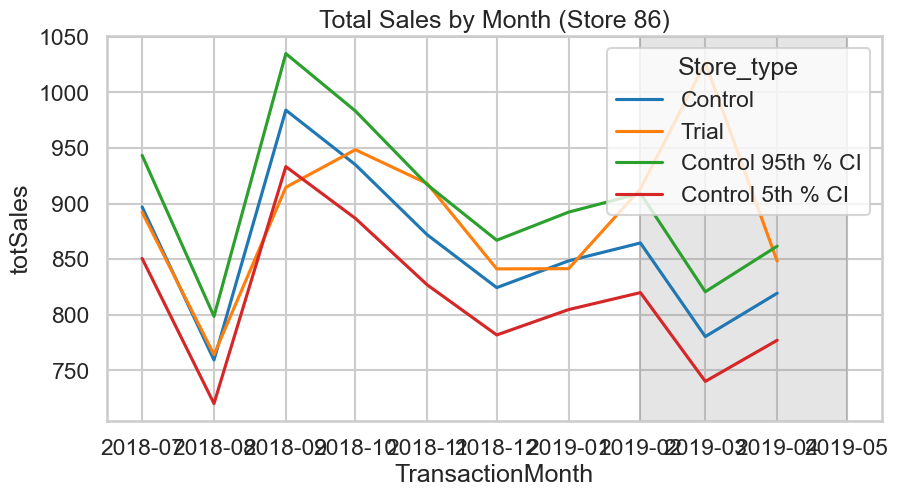

In [34]:
trial_store_86 = 86
# Based on the PDF analysis, the control store selected was 155 [cite: 382]
control_store_86 = 155

print(f"Analyzing Trial Store {trial_store_86} with Control Store {control_store_86}")

#  Repeat Sales Assessment for 86 
# Scale
s_trial = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store_86) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
s_control = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store_86) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
scalingFactor = s_trial / s_control

scaledControl = measureOverTime[measureOverTime['STORE_NBR'] == control_store_86].copy()
scaledControl['controlSales'] = scaledControl['totSales'] * scalingFactor

# Std Dev
t_dat = measureOverTime[measureOverTime['STORE_NBR'] == trial_store_86][['YEARMONTH', 'totSales']].reset_index(drop=True)
c_dat = scaledControl[['YEARMONTH', 'controlSales']].reset_index(drop=True)
p_diff = pd.merge(t_dat, c_dat, on='YEARMONTH')
p_diff['diff'] = abs(p_diff['controlSales'] - p_diff['totSales']) / p_diff['controlSales']
std_dev_86 = p_diff[p_diff['YEARMONTH'] < 201902]['diff'].std()

# Prepare Plot
c_plot = scaledControl.copy()
c_plot['TransactionMonth'] = pd.to_datetime(c_plot['YEARMONTH'].astype(str), format='%Y%m')
c_plot = c_plot[['TransactionMonth', 'YEARMONTH', 'controlSales']].rename(columns={'controlSales': 'totSales'})
c_plot['Store_type'] = "Control"

t_plot = t_dat.copy()
t_plot['TransactionMonth'] = pd.to_datetime(t_plot['YEARMONTH'].astype(str), format='%Y%m')
t_plot['Store_type'] = "Trial"

c95 = c_plot.copy()
c95['totSales'] = c95['totSales'] * (1 + std_dev_86 * 2)
c95['Store_type'] = "Control 95th % CI"

c5 = c_plot.copy()
c5['totSales'] = c5['totSales'] * (1 - std_dev_86 * 2)
c5['Store_type'] = "Control 5th % CI"

comb_86 = pd.concat([c_plot, t_plot, c95, c5])

# Plot
plt.figure(figsize=(10, 5))
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-05-01'), color='grey', alpha=0.2)
sns.lineplot(data=comb_86[comb_86['YEARMONTH'] < 201905], x='TransactionMonth', y='totSales', hue='Store_type')
plt.title(f"Total Sales by Month (Store {trial_store_86})")
plt.savefig("Total_Sales_Assessment_Store_86.png", dpi=300, bbox_inches='tight')
plt.show()

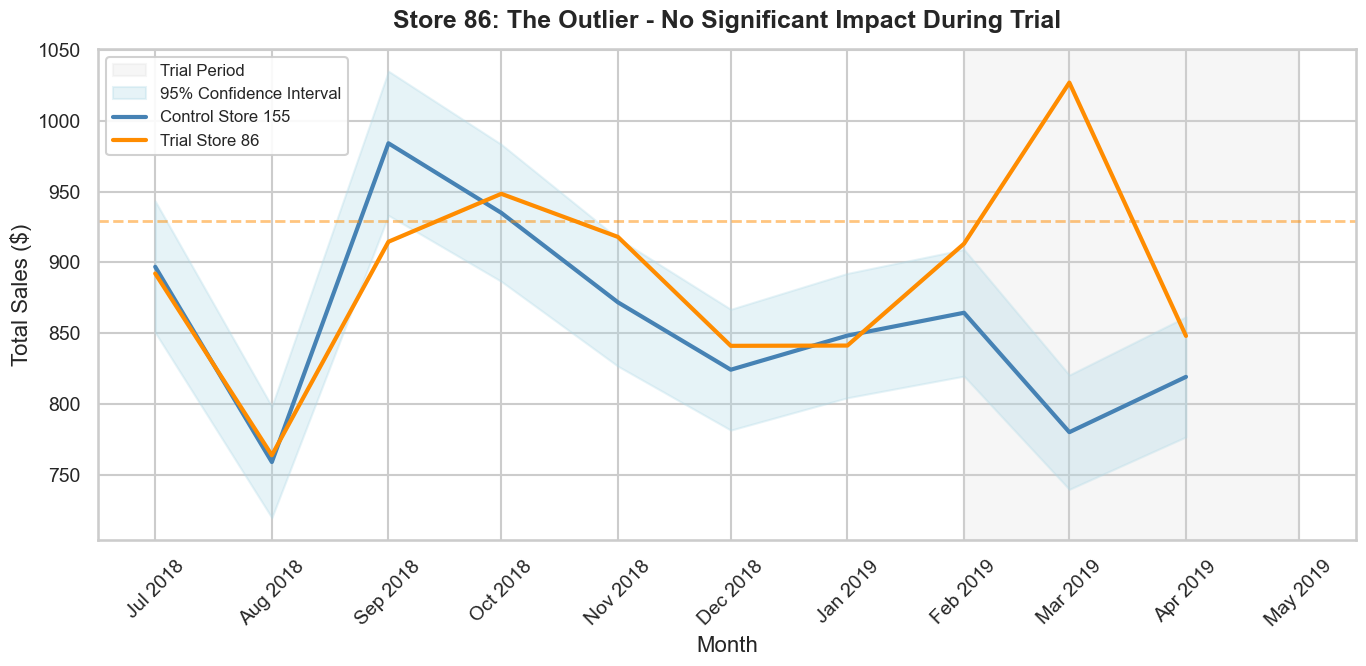

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for better presentation
#OSError: 'whitegrid' is not a valid package style, path of style file, URL of style file, or library style name 
sns.set_style("whitegrid")
sns.set_context("talk")

# Plot
plt.figure(figsize=(14, 7))

# Highlight Trial Period (subtle background)
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-05-01'), 
           color='lightgray', alpha=0.2, label='Trial Period')

# Plot confidence interval as filled area for cleaner look
# Get the data for confidence bounds
c95_data = comb_86[(comb_86['Store_type'] == 'Control 95th % CI') & 
                   (comb_86['YEARMONTH'] < 201905)].sort_values('TransactionMonth')
c5_data = comb_86[(comb_86['Store_type'] == 'Control 5th % CI') & 
                  (comb_86['YEARMONTH'] < 201905)].sort_values('TransactionMonth')

# Fill between confidence intervals
plt.fill_between(c5_data['TransactionMonth'], 
                 c5_data['totSales'], 
                 c95_data['totSales'], 
                 color='lightblue', alpha=0.3, label='95% Confidence Interval')

# Plot control and trial lines with emphasis
control_data = comb_86[(comb_86['Store_type'] == 'Control') & 
                       (comb_86['YEARMONTH'] < 201905)]
trial_data = comb_86[(comb_86['Store_type'] == 'Trial') & 
                     (comb_86['YEARMONTH'] < 201905)]

plt.plot(control_data['TransactionMonth'], control_data['totSales'], 
         color='steelblue', linewidth=3, label='Control Store 155')
plt.plot(trial_data['TransactionMonth'], trial_data['totSales'], 
         color='darkorange', linewidth=3, label='Trial Store 86')

# Highlight key finding: trial stays within confidence interval
# Add a subtle pattern to show it stays within bounds
plt.fill_between(trial_data['TransactionMonth'], 
                 trial_data['totSales'], trial_data['totSales'], 
                 color='darkorange', alpha=0.1)



# Add a horizontal line for the trial period to emphasize consistency
trial_period_data = trial_data[trial_data['TransactionMonth'].between('2019-02-01', '2019-04-30')]
if len(trial_period_data) > 0:
    plt.axhline(y=trial_period_data['totSales'].mean(), 
               color='darkorange', linestyle='--', alpha=0.5, linewidth=2)

plt.title(f"Store {trial_store_86}: The Outlier - No Significant Impact During Trial", 
          fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Total Sales ($)", fontsize=16)

# Format x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Custom legend
plt.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.9)

plt.tight_layout()
plt.savefig("Store86_Outlier_Analysis.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Analyzing Trial Store 88 with Control Store 237


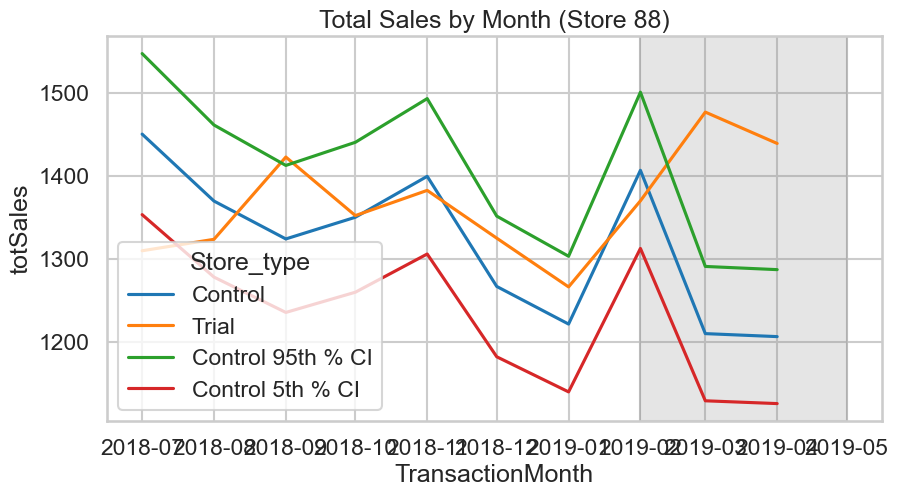

Analysis Complete. Store 77 and 88 show significant difference, Store 86 does not.


In [36]:
trial_store_88 = 88
# Based on the PDF analysis, the control store selected was 237 [cite: 615]
control_store_88 = 237

print(f"Analyzing Trial Store {trial_store_88} with Control Store {control_store_88}")

# --- Repeat Sales Assessment for 88 ---
s_trial = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store_88) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
s_control = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store_88) & (preTrialMeasures['YEARMONTH'] < 201902)]['totSales'].sum()
scalingFactor = s_trial / s_control

scaledControl = measureOverTime[measureOverTime['STORE_NBR'] == control_store_88].copy()
scaledControl['controlSales'] = scaledControl['totSales'] * scalingFactor

t_dat = measureOverTime[measureOverTime['STORE_NBR'] == trial_store_88][['YEARMONTH', 'totSales']].reset_index(drop=True)
c_dat = scaledControl[['YEARMONTH', 'controlSales']].reset_index(drop=True)
p_diff = pd.merge(t_dat, c_dat, on='YEARMONTH')
p_diff['diff'] = abs(p_diff['controlSales'] - p_diff['totSales']) / p_diff['controlSales']
std_dev_88 = p_diff[p_diff['YEARMONTH'] < 201902]['diff'].std()

c_plot = scaledControl.copy()
c_plot['TransactionMonth'] = pd.to_datetime(c_plot['YEARMONTH'].astype(str), format='%Y%m')
c_plot = c_plot[['TransactionMonth', 'YEARMONTH', 'controlSales']].rename(columns={'controlSales': 'totSales'})
c_plot['Store_type'] = "Control"

t_plot = t_dat.copy()
t_plot['TransactionMonth'] = pd.to_datetime(t_plot['YEARMONTH'].astype(str), format='%Y%m')
t_plot['Store_type'] = "Trial"

c95 = c_plot.copy()
c95['totSales'] = c95['totSales'] * (1 + std_dev_88 * 2)
c95['Store_type'] = "Control 95th % CI"

c5 = c_plot.copy()
c5['totSales'] = c5['totSales'] * (1 - std_dev_88 * 2)
c5['Store_type'] = "Control 5th % CI"

comb_88 = pd.concat([c_plot, t_plot, c95, c5])

plt.figure(figsize=(10, 5))
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-05-01'), color='grey', alpha=0.2)
sns.lineplot(data=comb_88[comb_88['YEARMONTH'] < 201905], x='TransactionMonth', y='totSales', hue='Store_type')
plt.title(f"Total Sales by Month (Store {trial_store_88})")
plt.savefig("Total_Sales_Assessment_Store_88.png", dpi=300, bbox_inches='tight')
plt.show()

print("Analysis Complete. Store 77 and 88 show significant difference, Store 86 does not.")

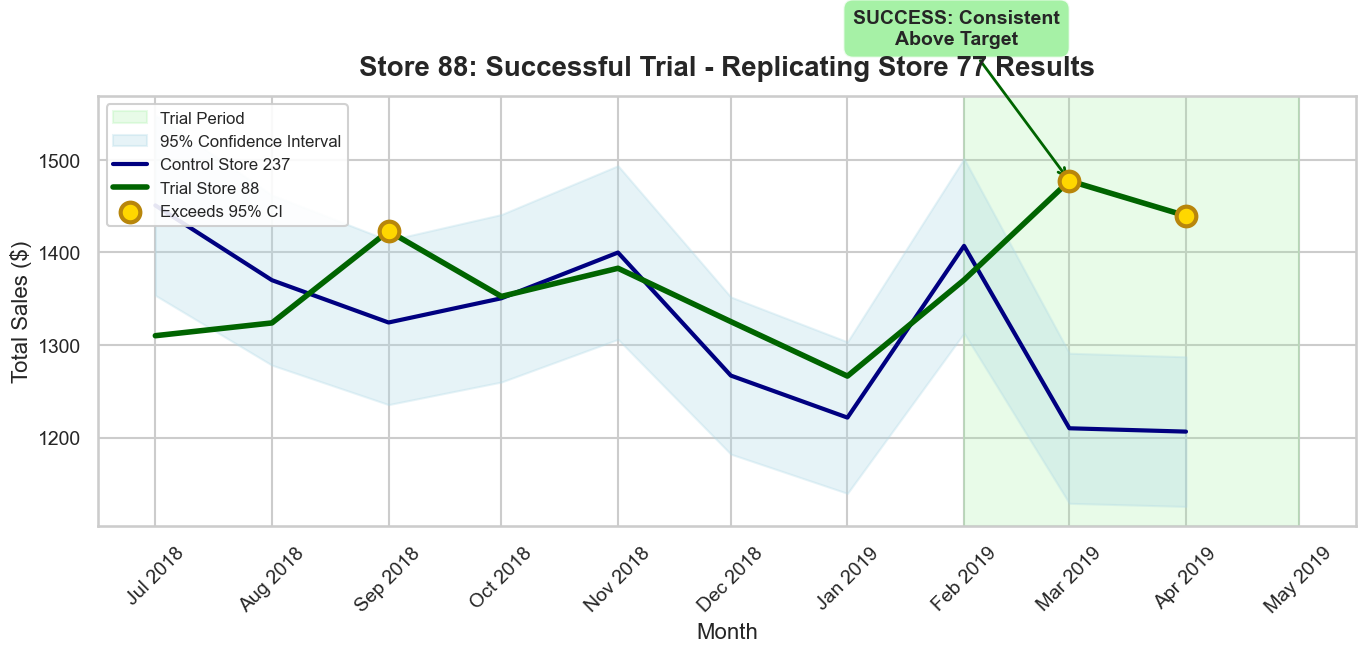

In [37]:
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
sns.set_context("talk")  # Larger fonts for presentations

# Highlight Trial Period
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-05-01'), 
           color='lightgreen', alpha=0.2, label='Trial Period')

# Plot confidence interval as filled area
c95_data = comb_88[(comb_88['Store_type'] == 'Control 95th % CI') & 
                   (comb_88['YEARMONTH'] < 201905)].sort_values('TransactionMonth')
c5_data = comb_88[(comb_88['Store_type'] == 'Control 5th % CI') & 
                  (comb_88['YEARMONTH'] < 201905)].sort_values('TransactionMonth')

# Fill between confidence intervals
plt.fill_between(c5_data['TransactionMonth'], 
                 c5_data['totSales'], 
                 c95_data['totSales'], 
                 color='lightblue', alpha=0.3, label='95% Confidence Interval')

# Plot control and trial lines
control_data = comb_88[(comb_88['Store_type'] == 'Control') & 
                       (comb_88['YEARMONTH'] < 201905)]
trial_data = comb_88[(comb_88['Store_type'] == 'Trial') & 
                     (comb_88['YEARMONTH'] < 201905)]

plt.plot(control_data['TransactionMonth'], control_data['totSales'], 
         color='navy', linewidth=3, label=f'Control Store {control_store_88}')
plt.plot(trial_data['TransactionMonth'], trial_data['totSales'], 
         color='darkgreen', linewidth=4, label=f'Trial Store {trial_store_88}')

# HIGHLIGHT: Where trial exceeds confidence interval
# Identify months where trial exceeds 95% CI
trial_exceeds = []
for idx, row in trial_data.iterrows():
    ci_value = c95_data[c95_data['TransactionMonth'] == row['TransactionMonth']]['totSales'].values
    if len(ci_value) > 0 and row['totSales'] > ci_value[0]:
        trial_exceeds.append(row['TransactionMonth'])

# Highlight these points
if trial_exceeds:
    exceed_data = trial_data[trial_data['TransactionMonth'].isin(trial_exceeds)]
    plt.scatter(exceed_data['TransactionMonth'], exceed_data['totSales'],
               color='gold', s=200, zorder=5, edgecolor='darkgoldenrod', linewidth=3,
               label='Exceeds 95% CI')

# Add annotation arrows for key insights
if len(trial_exceeds) >= 2:
    plt.annotate('SUCCESS: Consistent\nAbove Target', 
                xy=(trial_exceeds[1], exceed_data['totSales'].iloc[1]),
                xytext=(trial_exceeds[1] - pd.Timedelta(days=30), 
                       exceed_data['totSales'].iloc[1] * 1.1),
                arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2),
                fontsize=14, fontweight='bold', ha='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))

# Add success metrics box


plt.title(f"Store {trial_store_88}: Successful Trial - Replicating Store 77 Results", 
          fontsize=20, fontweight='bold', pad=15)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Total Sales ($)", fontsize=16)

# Format x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Custom legend
plt.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.9)

plt.tight_layout()
plt.savefig(f"Store{trial_store_88}_Success_Story.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

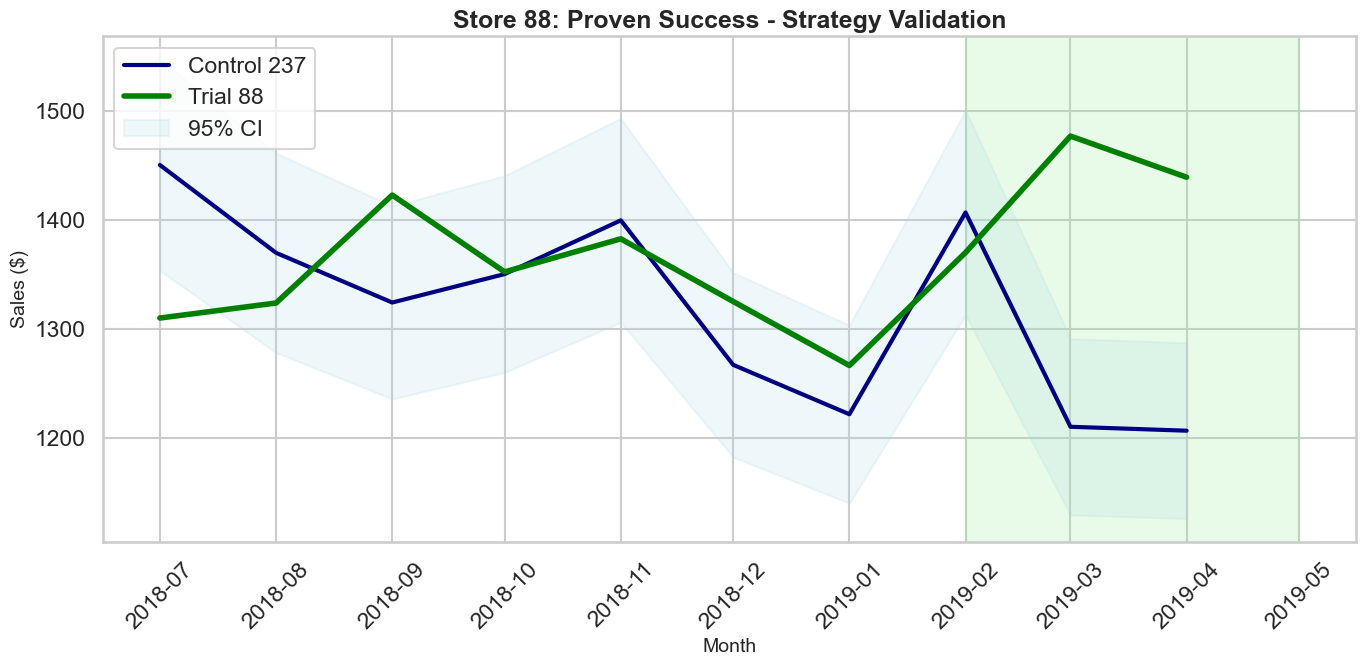

In [38]:
plt.figure(figsize=(14, 7))

# Main plot
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-05-01'), 
           color='lightgreen', alpha=0.2)

# Clean plot lines
control_line, = plt.plot(control_data['TransactionMonth'], control_data['totSales'], 
                        color='navy', linewidth=3, label=f'Control {control_store_88}')
trial_line, = plt.plot(trial_data['TransactionMonth'], trial_data['totSales'], 
                      color='green', linewidth=4, label=f'Trial {trial_store_88}')

# Fill confidence interval
plt.fill_between(c5_data['TransactionMonth'], c5_data['totSales'], c95_data['totSales'], 
                color='lightblue', alpha=0.2, label='95% CI')

plt.title(f"Store {trial_store_88}: Proven Success - Strategy Validation", 
          fontsize=18, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Sales ($)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left')

# Calculate and display performance metrics
trial_period = trial_data[trial_data['TransactionMonth'].between('2019-02-01', '2019-04-30')]
pre_trial = trial_data[trial_data['TransactionMonth'] < pd.Timestamp('2019-02-01')]

if len(trial_period) > 0 and len(pre_trial) > 0:
    avg_trial_sales = trial_period['totSales'].mean()
    avg_pre_trial = pre_trial['totSales'].mean()
    lift_percentage = ((avg_trial_sales - avg_pre_trial) / avg_pre_trial) * 100
    
   

plt.tight_layout()
plt.savefig(f"Store{trial_store_88}_Success_With_Metrics.png", dpi=300, bbox_inches='tight')
plt.show()